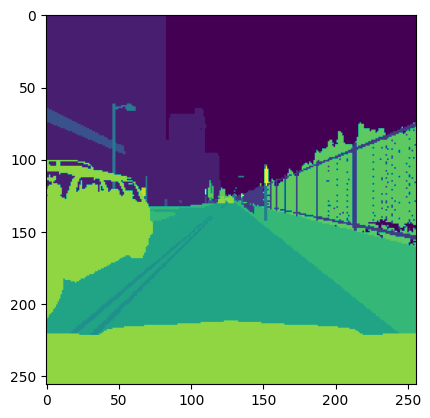

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os


img_path = "/kaggle/input/cv-a4-q2/dataset_256/train/images/02_00_000.png"
label_path = "/kaggle/input/cv-a4-q2/dataset_256/train/labels/02_00_000.png"

mask = cv2.imread(label_path)
plt.imshow(mask[:,:,2])


In [9]:

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


class Data(Dataset):
    def __init__(self, root_dir, transform=None):

        self.image_dir = os.path.join(root_dir, "images")
        self.label_dir = os.path.join(root_dir, "labels")
        self.image_filenames = sorted([f for f in os.listdir(self.image_dir) if f.endswith('.png')])
        self.label_filenames = sorted([f for f in os.listdir(self.label_dir) if f.endswith('.png')])

        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):

        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        image = cv2.imread(img_path)  
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

        label_path = os.path.join(self.label_dir, self.label_filenames[idx])
        mask = cv2.imread(label_path) 
        mask = mask[:,:,2]

        if self.transform:
            image = self.transform(image)


        mask = torch.tensor(mask, dtype=torch.long) 

        return image, mask

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



In [10]:

batch_size = 16

dataset = Data(root_dir="/kaggle/input/cv-a4-q2/dataset_256/train", transform=transform)

train_size = int(0.75 * len(dataset))

val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

test_dataset = Data(root_dir="/kaggle/input/cv-a4-q2/dataset_256/test", transform=transform)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


len(dataset)

2000

In [11]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [ ]:

import torch.nn as nn


class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):

        super(AttentionGate, self).__init__()
        
        # Gating path (for the gating signal from the deeper layer)
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        # Skip connection path
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        # Attention coefficient computation
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, g, x):

        # Map the gating signal to intermediate dimension // keys
        g1 = self.W_g(g)
        
        # Map the skip connection features to intermediate dimension // query
        x1 = self.W_x(x)
        
        # Element-wise sum and ReLU activation
        psi = self.relu(g1 + x1)  # Addition of the features (as shown in the image)
        
        # Get attention map - coefficient α is set to 1 as specified
        psi = self.psi(psi)
        
        # Element-wise multiplication of attention coefficients with skip features
        return x * psi  # Element-wise multiplication for attention


class double_convolution(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(double_convolution, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.conv(x)


class AttentionUNet(nn.Module):
    def __init__(self, num_classes, in_channels=3):
        super(AttentionUNet, self).__init__()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Encoder
        self.encoder_1 = double_convolution(in_channels, 64)
        self.encoder_2 = double_convolution(64, 128)
        self.encoder_3 = double_convolution(128, 256)
        self.encoder_4 = double_convolution(256, 512)
        
        # Bottleneck
        self.bottleneck = double_convolution(512, 1024)
        
        # Attention Gates
        self.attention_gate1 = AttentionGate(F_g=512, F_l=512, F_int=256)
        self.attention_gate2 = AttentionGate(F_g=256, F_l=256, F_int=128)
        self.attention_gate3 = AttentionGate(F_g=128, F_l=128, F_int=64)
        
        # Decoder with upsampling
        self.up_transpose_1 = nn.ConvTranspose2d(
            in_channels=1024, out_channels=512,
            kernel_size=2,
            stride=2
        )
        self.decoder_1 = double_convolution(1024, 512)  # 512+512 input
        
        self.up_transpose_2 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256,
            kernel_size=2,
            stride=2
        )
        self.decoder_2 = double_convolution(512, 256)  # 256+256 input
        
        self.up_transpose_3 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128,
            kernel_size=2,
            stride=2
        )
        self.decoder_3 = double_convolution(256, 128)  # 128+128 input
        
        self.up_transpose_4 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64,
            kernel_size=2,
            stride=2
        )
        self.decoder_4 = double_convolution(128, 64)  # 64+64 input
        
        self.output = nn.Conv2d(
            in_channels=64, out_channels=num_classes,
            kernel_size=1
        )
    
    def forward(self, x):
        # Encoder
        enc1 = self.encoder_1(x)
        x = self.max_pool2d(enc1)
        
        enc2 = self.encoder_2(x)
        x = self.max_pool2d(enc2)
        
        enc3 = self.encoder_3(x)
        x = self.max_pool2d(enc3)
        
        enc4 = self.encoder_4(x)
        x = self.max_pool2d(enc4)
        
        # Bottleneck
        x = self.bottleneck(x)
        
        # Decoder with attention gates
        x = self.up_transpose_1(x)
        # Apply attention gate to encoder features before concatenation
        gated_enc4 = self.attention_gate1(x, enc4)
        x = self.decoder_1(torch.cat([gated_enc4, x], dim=1))
        
        x = self.up_transpose_2(x)
        # Apply attention gate
        gated_enc3 = self.attention_gate2(x, enc3)
        x = self.decoder_2(torch.cat([gated_enc3, x], dim=1))
        
        x = self.up_transpose_3(x)
        # Apply attention gate
        gated_enc2 = self.attention_gate3(x, enc2)
        x = self.decoder_3(torch.cat([gated_enc2, x], dim=1))
        
        x = self.up_transpose_4(x)
        # Note: No attention gate for the shallowest level as per diagram
        x = self.decoder_4(torch.cat([enc1, x], dim=1))
        
        return self.output(x)

In [13]:
import torch.optim as optim
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
import torchmetrics
from torchmetrics.segmentation import MeanIoU

BATCH_SIZE = 5
LEARNING_RATE = 0.001
NUM_EPOCHS = 24
NUM_CLASSES = 13
IMAGE_SIZE = 256

model = AttentionUNet(num_classes=NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

val_miou = MeanIoU(num_classes=NUM_CLASSES).to(device)
test_miou = MeanIoU(num_classes=NUM_CLASSES).to(device)


In [14]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
  
    
    for images, masks in tqdm(loader, desc="Training"):
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
    
    
    
    return epoch_loss / len(loader)

In [15]:
def validate(model, loader, criterion, miou_metric, device):
    model.eval()
    val_loss = 0
    miou_metric.reset()  
    
    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Validation"):
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            miou_metric.update(preds, masks)
    
    epoch_miou = miou_metric.compute()
    
    return val_loss / len(loader), epoch_miou.item()

In [16]:
def test(model, loader, miou_metric, device):
    model.eval()
    miou_metric.reset() 
    all_images = []
    all_masks = []
    all_predictions = []
    
    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Testing"):
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)
            
       
            miou_metric.update(predictions, masks)
            
            
            if len(all_images) < 5: 
                all_images.extend(images.cpu())
                all_masks.extend(masks.cpu())
                all_predictions.extend(predictions.cpu())
    
   
    final_miou = miou_metric.compute().item()
    
    sample_images = torch.stack(all_images[:5])
    sample_masks = torch.stack(all_masks[:5])
    sample_predictions = torch.stack(all_predictions[:5])
    
    return final_miou, sample_images, sample_masks, sample_predictions


In [ ]:
def visualize_results(images, masks, predictions):
    
    fig, axes = plt.subplots(len(images), 3, figsize=(12, 4*len(images)))
    
  
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    for i in range(len(images)):
        # Original image
        img = images[i].permute(1, 2, 0).cpu().numpy()
        img = img * std.permute(1, 2, 0).cpu().numpy() + mean.permute(1, 2, 0).cpu().numpy()
        img = np.clip(img, 0, 1)
        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis('off')
        
        # Ground truth mask
        mask = masks[i].cpu().numpy()
        axes[i, 1].imshow(mask, cmap='tab20')
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis('off')
        
        # Predicted mask
        pred = predictions[i].cpu().numpy()
        axes[i, 2].imshow(pred, cmap='tab20')
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()


In [18]:
def train_model():
    best_model_path = "best_unetvanilla_model.pth"

    os.makedirs("results", exist_ok=True)
    
    train_losses = []
    val_losses = []
    val_mious = []
    
    for epoch in range(NUM_EPOCHS):
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
        

        train_loss= train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_epoch_miou = validate(model, val_loader, criterion, val_miou, device)
        

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        val_mious.append(val_epoch_miou)

        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val mIoU: {val_epoch_miou:.4f}")
        
  
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(val_mious, label='Val mIoU')
    plt.xlabel('Epoch')
    plt.ylabel('mIoU')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return best_model_path



Training started
Epoch 1/24


Validation: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s]


Train Loss: 0.7821
Val Loss: 0.5600, Val mIoU: 0.6979
Epoch 2/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.31it/s]


Train Loss: 0.3298
Val Loss: 0.8029, Val mIoU: 0.6580
Epoch 3/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.50it/s]


Train Loss: 0.2619
Val Loss: 0.2472, Val mIoU: 0.8152
Epoch 4/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.50it/s]


Train Loss: 0.2172
Val Loss: 0.1944, Val mIoU: 0.8379
Epoch 5/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.39it/s]


Train Loss: 0.1920
Val Loss: 0.1887, Val mIoU: 0.8369
Epoch 6/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.33it/s]


Train Loss: 0.1616
Val Loss: 0.1489, Val mIoU: 0.8571
Epoch 7/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.19it/s]


Train Loss: 0.1473
Val Loss: 0.1583, Val mIoU: 0.8525
Epoch 8/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.24it/s]


Train Loss: 0.1313
Val Loss: 0.1458, Val mIoU: 0.8567
Epoch 9/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.42it/s]


Train Loss: 0.1294
Val Loss: 0.1290, Val mIoU: 0.8668
Epoch 10/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.32it/s]


Train Loss: 0.1140
Val Loss: 0.1165, Val mIoU: 0.8716
Epoch 11/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.36it/s]


Train Loss: 0.1028
Val Loss: 0.1118, Val mIoU: 0.8738
Epoch 12/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.36it/s]


Train Loss: 0.0948
Val Loss: 0.0950, Val mIoU: 0.8808
Epoch 13/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.43it/s]


Train Loss: 0.0879
Val Loss: 0.0954, Val mIoU: 0.8825
Epoch 14/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.44it/s]


Train Loss: 0.0824
Val Loss: 0.0955, Val mIoU: 0.8811
Epoch 15/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.50it/s]


Train Loss: 0.0883
Val Loss: 0.1125, Val mIoU: 0.8723
Epoch 16/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.48it/s]


Train Loss: 0.0861
Val Loss: 0.0843, Val mIoU: 0.8863
Epoch 17/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.43it/s]


Train Loss: 0.0691
Val Loss: 0.0755, Val mIoU: 0.8906
Epoch 18/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.50it/s]


Train Loss: 0.0668
Val Loss: 0.0782, Val mIoU: 0.8889
Epoch 19/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.41it/s]


Train Loss: 0.0606
Val Loss: 0.0673, Val mIoU: 0.8951
Epoch 20/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.44it/s]


Train Loss: 0.0774
Val Loss: 1.6357, Val mIoU: 0.6156
Epoch 21/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.40it/s]


Train Loss: 0.1570
Val Loss: 0.1245, Val mIoU: 0.8659
Epoch 22/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.41it/s]


Train Loss: 0.0814
Val Loss: 0.0783, Val mIoU: 0.8880
Epoch 23/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.39it/s]


Train Loss: 0.0666
Val Loss: 0.0728, Val mIoU: 0.8927
Epoch 24/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.39it/s]


Train Loss: 0.0593
Val Loss: 0.0662, Val mIoU: 0.8955


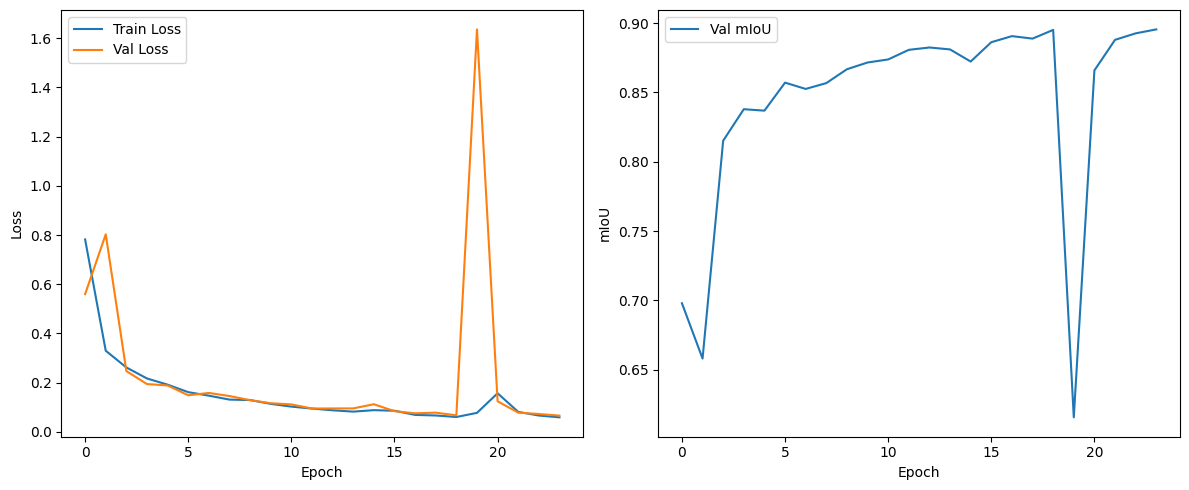

Training completed


Testing: 100%|██████████| 32/32 [00:10<00:00,  3.04it/s]


Test mIoU: 0.8938


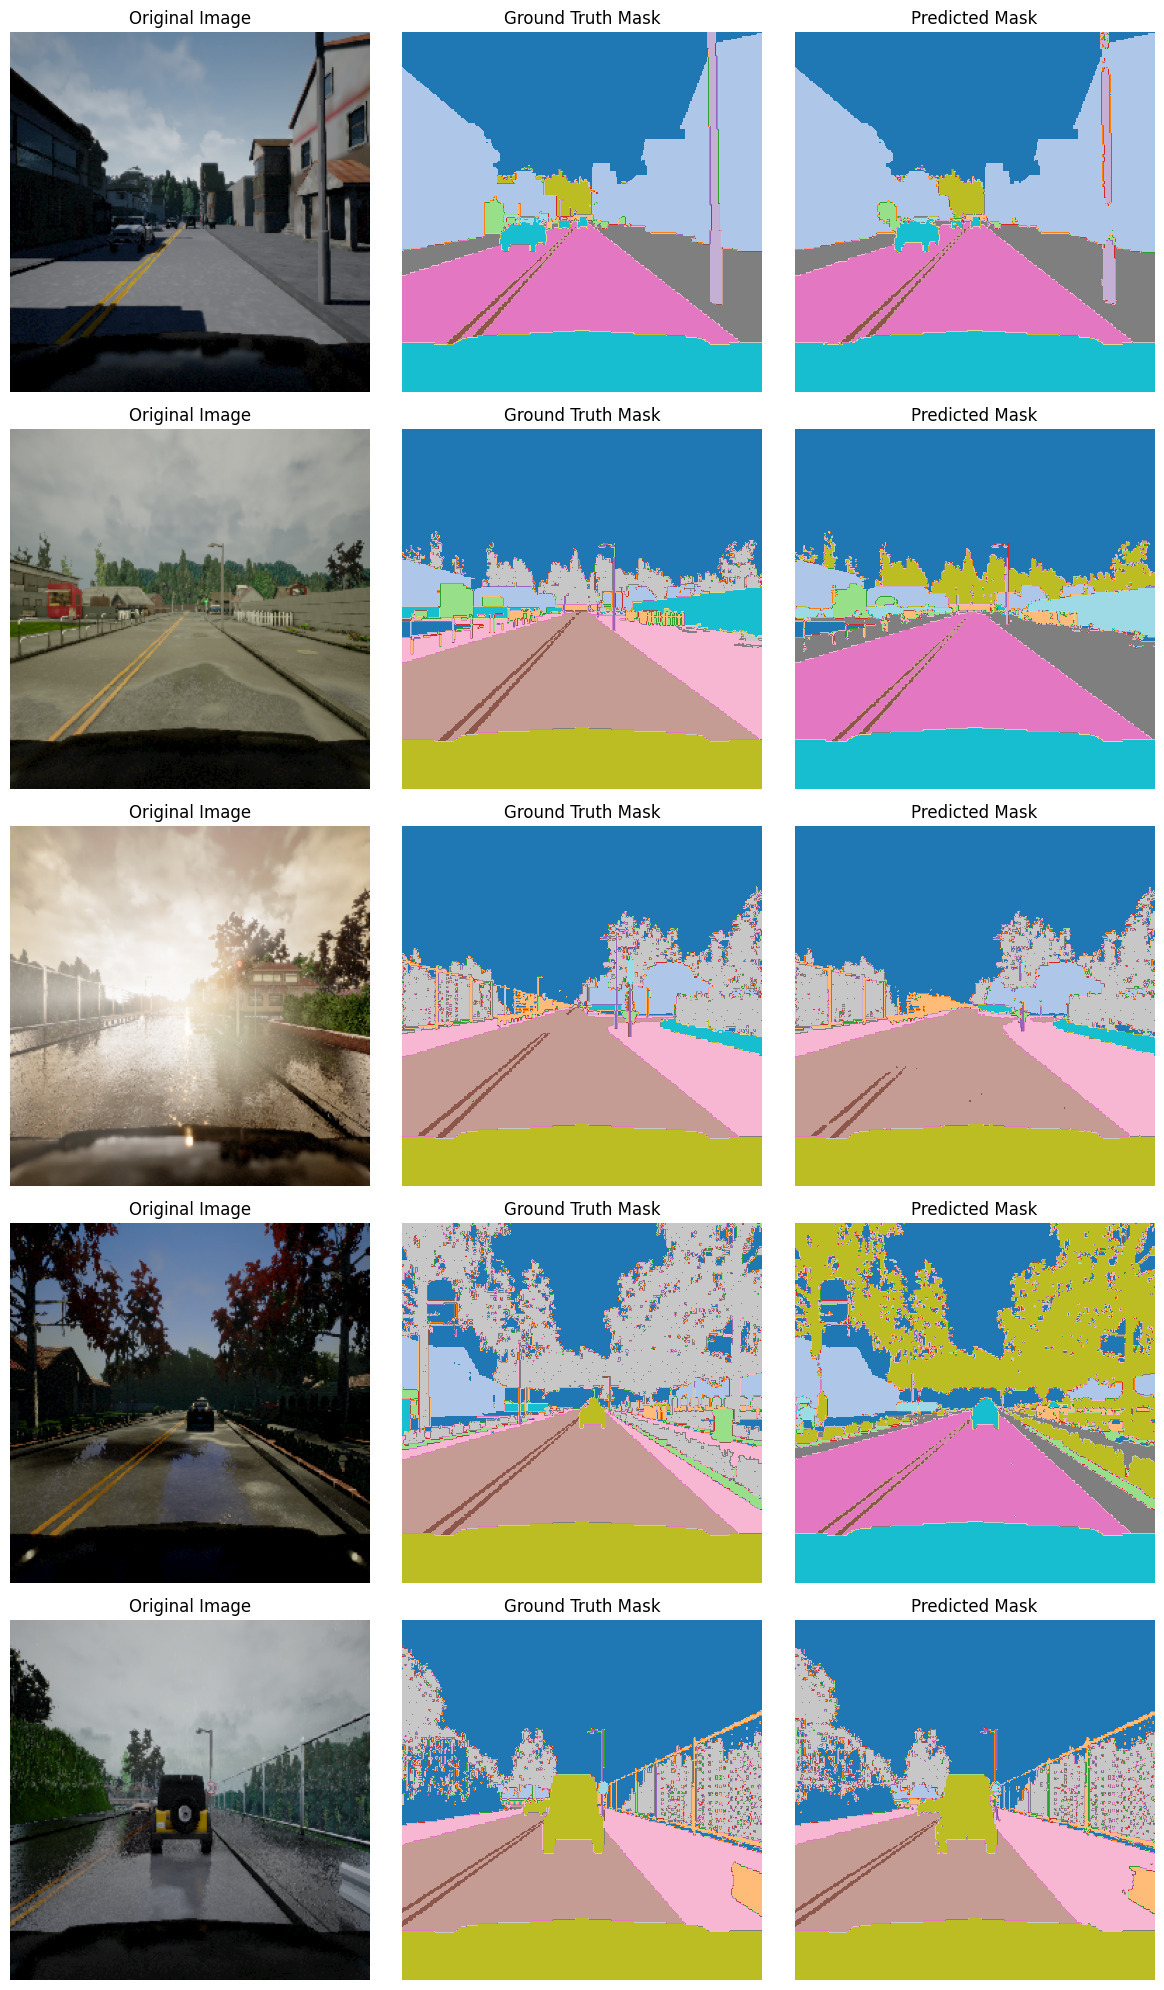

In [19]:


print(f"Training started")
best_model_path = train_model()
print(f"Training completed")

test_epoch_miou, sample_images, sample_masks, sample_predictions = test(model, test_loader, test_miou, device)
print(f"Test mIoU: {test_epoch_miou:.4f}")

visualize_results(sample_images, sample_masks, sample_predictions)
 